# Obesity or CVD risk analysis and clasification

The dataset contain information about levels of obesity and factors that define them of people from Mexico, Colombia and Peru.More information about this on the link below.

Data source: [Obesity or CVD risk](https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster)

### Next steps in order:

- EDA (exploration data analysis)
  - [Import and inspect data](#import-and-inspect-data)
  - [Handle missing values](#handle-missing-values)
  - [Transform features](#transform-features)
  - [Handle outliers](#handle-outliers)
  - [Explore data and visualization](#explore-data-and-visualization)
- [Train and predict](#train-and-predict) with the models. Evaluate them.
- [Conclusion](#conclusion)

### Objective

Classify the type of weight and know if a person has obesity and which type based on several attributes


In [187]:
# Installations

%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install plotly
%pip install matplotlib
%pip install nbformat

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [188]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import plotly.express as px
import plotly.graph_objects as go

# ML
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
)
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Others
import warnings

warnings.filterwarnings("ignore")

# EDA


### Import and inspect data


In [189]:
df = pd.read_csv(
    "ObesityDataSet.csv",
)

df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Features explanation:

- FAVC: Frequent consumption of high caloric food
- FCVC: Frequency of consumption of vegetables
- NCP: Number of main meals
- CAEC: Consumption of food between meals
- SMOKE: Is a smoker
- CH20: Consumption of water daily
- CALC: Consumption of alcohol
- SCC: Calories consumption monitoring
- FAF: Physical activity frequency
- TUE: Time using technology devices
- MTRANS: Transportation used
- NObesity: Type of weight based on body mass index (BMI)


### Handle missing values


In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

There are not missing values and at the moment all the features will be used


### Transform features

Check the values that those Dtype are object and transform them to a numeric value


In [191]:
for column in df.select_dtypes("object").columns:
    print(f"{column} have <{len(df[column].value_counts())}> possible values")

Gender have <2> possible values
family_history_with_overweight have <2> possible values
FAVC have <2> possible values
CAEC have <4> possible values
SMOKE have <2> possible values
SCC have <2> possible values
CALC have <4> possible values
MTRANS have <5> possible values
NObeyesdad have <7> possible values


In [192]:
# First those that only have 2 possible values with one hot encoder

two_options_features = df[
    ["Gender", "family_history_with_overweight", "FAVC", "SMOKE", "SCC"]
]

ct_one_hot = ColumnTransformer(
    [
        (
            "one_hot",
            OneHotEncoder(drop="first"),
            two_options_features.columns,
        ),
    ]
)

encoded_one_hot = pd.DataFrame(
    ct_one_hot.fit_transform(two_options_features), columns=two_options_features.columns
)

df[encoded_one_hot.columns] = encoded_one_hot

In [193]:
# Now the rest with label encoder

NObeyesdad_text = df["NObeyesdad"]

several_options_features = ["CAEC", "CALC", "MTRANS", "NObeyesdad"]

for column in several_options_features:
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])

df.dtypes

Gender                            float64
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight    float64
FAVC                              float64
FCVC                              float64
NCP                               float64
CAEC                                int64
SMOKE                             float64
CH2O                              float64
SCC                               float64
FAF                               float64
TUE                               float64
CALC                                int64
MTRANS                              int64
NObeyesdad                          int64
dtype: object

### Handle outliers


In [194]:
df.describe()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,0.505921,24.312600,1.701677,86.586058,0.817622,0.883941,2.419043,2.685628,1.859308,0.020843,2.008011,0.045476,1.010298,0.657866,2.268593,2.365230,3.015632
std,0.500083,6.345968,0.093305,26.191172,0.386247,0.320371,0.533927,0.778039,0.468543,0.142893,0.612953,0.208395,0.850592,0.608927,0.515498,1.261423,1.952090
min,0.000000,14.000000,1.450000,39.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.947192,1.630000,65.473343,1.000000,1.000000,2.000000,2.658738,2.000000,0.000000,1.584812,0.000000,0.124505,0.000000,2.000000,3.000000,1.000000
50%,1.000000,22.777890,1.700499,83.000000,1.000000,1.000000,2.385502,3.000000,2.000000,0.000000,2.000000,0.000000,1.000000,0.625350,2.000000,3.000000,3.000000
75%,1.000000,26.000000,1.768464,107.430682,1.000000,1.000000,3.000000,3.000000,2.000000,0.000000,2.477420,0.000000,1.666678,1.000000,3.000000,3.000000,5.000000
max,1.000000,61.000000,1.980000,173.000000,1.000000,1.000000,3.000000,4.000000,3.000000,1.000000,3.000000,1.000000,3.000000,2.000000,3.000000,4.000000,6.000000


In [195]:
# Standarize the values to do a boxplot just with the values which were initially a number

df_initially_numbers = df.iloc[
    :, ~df.columns.isin([*two_options_features.columns, *several_options_features])
]

std_scaler_ct = ColumnTransformer(
    [("std_scaler", StandardScaler(), df_initially_numbers.columns)]
)

df_init_num_standarized = pd.DataFrame(
    std_scaler_ct.fit_transform(df_initially_numbers),
    columns=df_initially_numbers.columns,
)

df_init_num_standarized.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997
1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625
2,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997
3,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625
4,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625


In [196]:
px.box(df_init_num_standarized)

Even if age can looks that have outliers they pretty sure are not because the min and max are 14 and 61 which are normal values in this context


### Explore data and visualization

Dimensions will be reduced with PCA to plot all the features in 2 dimensions


In [197]:
X = df.iloc[:, :-1]
y = df["NObeyesdad"]

pca = PCA(2)
pca_df = pd.DataFrame(pca.fit_transform(X))

In [198]:
px.scatter(
    pca_df,
    x=0,
    y=1,
    color=NObeyesdad_text,
    labels={"0": "X", "1": "Y", "color": "Weight type"},
)

In [199]:
px.pie(pca_df, names=NObeyesdad_text)

In [200]:
# Filtering by NObeyesdad correlation values which have 0.3 score or more

obesity_highest_corr = df.corr().query("NObeyesdad > 0.3")[
    df.corr().query("NObeyesdad > 0.3").index
]

px.imshow(obesity_highest_corr, text_auto=True, color_continuous_scale="ylorrd")

- Scatter plot: different groups can be spotted and makes sense that category insufficient weight is away from category obesity type 3.
- Pie plot: the count cases of each category go on decrease of obesity, this mean that the majority of categories are obesity, overweight, normal and then insufficient, in that order.
- Correlation matrix: highest correlation with the level of obesity are weight, family history with overweight and CAEC (consumtion of food between meals).


# Train and predict

To make the classifications the models that will be trained are logistic regression, KNN, random forest and gradient boosting


In [201]:
seed = 0

report = pd.DataFrame(columns=["Model", "Accuracy"])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

def get_best_clasification_report(model, params):
    random_search = RandomizedSearchCV(model, params, random_state=seed).fit(
        X_train, y_train
    )

    y_pred = random_search.best_estimator_.predict(X_test)
    report.loc[len(report)] = [model.__str__()[:-2], f1_score(y_test, y_pred, average='micro')]

    print(f"Best params for {model}: {random_search.best_params_}")
    print(classification_report(y_test, y_pred))
    
    return random_search.best_estimator_

In [202]:
log_params = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": [0.1, 1, 10],
    "max_iter": [100, 500, 1000],
}

_ = get_best_clasification_report(LogisticRegression(), log_params)

Best params for LogisticRegression(): {'penalty': 'l2', 'max_iter': 500, 'C': 1}
              precision    recall  f1-score   support

           0       0.80      0.85      0.82        78
           1       0.60      0.59      0.60        69
           2       0.74      0.78      0.76        86
           3       0.88      0.96      0.92        73
           4       0.97      1.00      0.98        88
           5       0.65      0.57      0.61        68
           6       0.61      0.53      0.57        66

    accuracy                           0.77       528
   macro avg       0.75      0.75      0.75       528
weighted avg       0.76      0.77      0.76       528



In [203]:
knn_params = {"n_neighbors": np.arange(3, 9, 2)}

_ = get_best_clasification_report(KNeighborsClassifier(), knn_params)

Best params for KNeighborsClassifier(): {'n_neighbors': np.int64(3)}
              precision    recall  f1-score   support

           0       0.82      0.99      0.90        78
           1       0.77      0.59      0.67        69
           2       0.92      0.95      0.94        86
           3       0.97      1.00      0.99        73
           4       0.99      1.00      0.99        88
           5       0.86      0.84      0.85        68
           6       0.90      0.85      0.88        66

    accuracy                           0.90       528
   macro avg       0.89      0.89      0.89       528
weighted avg       0.90      0.90      0.89       528



In [204]:
rf_params = {
    "n_estimators": [100, 110, 120],
    "min_samples_split": [4, 5],
    "min_samples_leaf": [4, 5],
}


rf = get_best_clasification_report(RandomForestClassifier(), rf_params)

Best params for RandomForestClassifier(): {'n_estimators': 120, 'min_samples_split': 4, 'min_samples_leaf': 5}
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        78
           1       0.77      0.97      0.86        69
           2       0.97      0.99      0.98        86
           3       0.99      0.97      0.98        73
           4       1.00      1.00      1.00        88
           5       0.93      0.78      0.85        68
           6       0.94      0.89      0.91        66

    accuracy                           0.94       528
   macro avg       0.94      0.93      0.93       528
weighted avg       0.95      0.94      0.94       528



In [205]:
gb_params = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1, 1],
    "max_depth": [3, 5, 7],
}

gb = get_best_clasification_report(GradientBoostingClassifier(), gb_params)

Best params for GradientBoostingClassifier(): {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}
              precision    recall  f1-score   support

           0       0.96      0.95      0.95        78
           1       0.89      0.94      0.92        69
           2       0.97      1.00      0.98        86
           3       1.00      0.99      0.99        73
           4       1.00      1.00      1.00        88
           5       0.98      0.90      0.94        68
           6       0.96      0.97      0.96        66

    accuracy                           0.97       528
   macro avg       0.97      0.96      0.96       528
weighted avg       0.97      0.97      0.97       528



In [206]:
report.sort_values('Accuracy', ascending=False)

,Model,Accuracy
3,GradientBoostingClassifier,0.965909
2,RandomForestClassifier,0.939394
1,KNeighborsClassifier,0.897727
0,LogisticRegression,0.768939


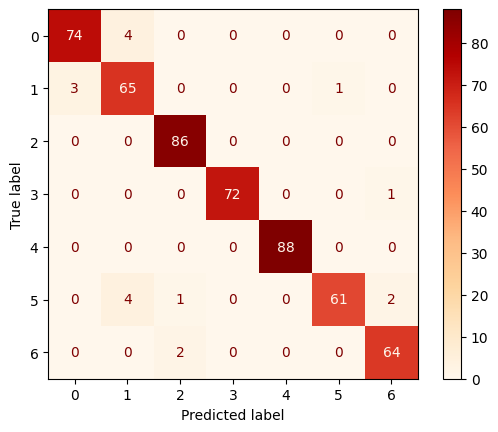

In [207]:
y_pred = gb.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='OrRd')

In [208]:
y_pred_prob = gb.predict_proba(X_test)

fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for i in range(y_pred_prob.shape[1]):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:,i], pos_label=i)

    name = NObeyesdad_text[i]
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=1100, height=600
)
fig.show()

# Conclusion

The most accurate estimate in this analysis is provided by the Gradient Boosting with an accuracy of <b>96.59%</b> but the training have much more cost than the random forest (147.5 vs 9.3 seconds respectively).

The main factors that define if someone can have some kind of overweight or worse are the weight itself, if the family person tend to have weight issues or if this person eat food between meals, so try to avoid the last one could help the individual to prevent health issues.